<a href="https://colab.research.google.com/github/saeidscorp/ipm-ai-summer-school/blob/master/IMDB_Sentiment_Analysis_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meta

### TODO
- [x] Fix the random seed
- [x] Preprocess text properly
  - [x] Use spacy for lemmatization
    - [ ] Test stop-word removal
    - [ ] ~~Switch to spacy pipes and apply to batches~~
  - [x] Map each input to token ids vector (from BERT tokenizer)
- [x] Pad batches
- [x] Save intermediate dataset to drive
  - ~~`TFRecord` needs manual (de)serialization~~
  - [ ] ~~Use `tf.data.experimental.save` instead~~
  - [x] (Maybe an alternative:) Add cache-to-file in the pipeline
  - [x] Add a widget to clear caches
    - [ ] Extend it to clear any cache used anywhere
  - [ ] ~~Conditionally use the cached dataset or generate from scratch~~
    - Not needed for cache-to-file
- [x] Test BERT + Dense
  - Failed miserably
- [ ] Shuffle training data between batches (repeat().shuffle().batch())
- [ ] Architectures
  - [x] Test Dense
  - [x] Test ConvNet
  - [x] Test LSTM
    - Failed
    - [x] Test LSTM + Conv
      - Finally by reducing LSTM's size, some acceptable result
  - [x] Test Conv + LSTM
  - [ ] Test GRU

## Notes
- Preprocessing + shuffling + batching for train_ds, val_ds, test_ds each takes 20 mins now.

# Initialization & Data

## Mounting My Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dear TA, mounting a drive isn't necessary since the following snippet will create the directories (just in case)

In [ ]:
!mkdir -p '/content/drive/My Drive/IPM AI/Models/'
!mkdir -p '/content/drive/My Drive/IPM AI/caches/'

## Libraries
- TensorFlow
- Keras
- NumPy
- spaCy
- Google BERT

In [ ]:
# import libraries & download datasets

%load_ext tensorboard

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_hub as hub

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

import datetime, os

tf.random.set_seed(1)  # consistent results

print("Fetching spaCy model...")
!python -m spacy download en_core_web_md
import spacy
from spacy.lang.en import English
print("Importing spaCy model...")
import en_core_web_md

print("Loading spaCy model...")
nlp = en_core_web_md.load(disable=['tagger', 'ner', 'textcat',
                                   'entity_ruler', 'entity_linker'])


print("Installing BERT for TF2...")
!pip install bert-for-tf2

print("\nLoading BERT model..")
import bert
bert_model_name = "wwm_uncased_L-24_H-1024_A-16"
# bert_model_name = "uncased_L-12_H-768_A-12"

bert_model_dir = bert.fetch_google_bert_model(bert_model_name, ".models")
bert_model_ckpt = os.path.join(bert_model_dir, "bert_model.ckpt")

bert_params = bert.params_from_pretrained_ckpt(bert_model_dir)

do_lower_case = not (bert_model_name.find("cased") == 0 or bert_model_name.find("multi_cased") == 0)
bert.bert_tokenization.validate_case_matches_checkpoint(do_lower_case, bert_model_ckpt)
bert_vocab_file = os.path.join(bert_model_dir, "vocab.txt")
bert_tokenizer = bert.bert_tokenization.FullTokenizer(bert_vocab_file, do_lower_case)

print("Done")

In [ ]:
elmo_url = "https://tfhub.dev/google/elmo/3"
#elmo = hub.Module(elmo_url, trainable=False)  # needs graph evaluation :(

## Preprocessing Methods

In [ ]:
import textwrap

text = ("Psychedelics (also known as serotonergic hallucinogens) are a class of psychoactive substances that produce an altered state of consciousness marked by unusual changes in perception, mood, and cognitive processes. "
"While their precise mechanism of action is not known, psychedelics are thought to produce their characteristic effects by binding to serotonin receptors (5HT), particularly the 5-HT2a subtype. "
"Serotonin plays a number of critical roles throughout the human body and is a key neurotransmitter involved in the functioning and regulation of sensory perception, behavior, mood, cognition and memory.\n\n"

"Human usage of psychedelics predates written history, and there is growing evidence that they were employed by early cultures in a variety of sociocultural and ritual contexts. "
"In modern times, psychedelic substances are used for a number of purposes that span from the traditional shamanic forms (such as the use of ayahuasca in the Amazon jungle, or peyote among Native Americans) to more modern forms of New Age spiritual, transpersonal, or religious practices. "
"Psychedelics, particularly those in the traditional or herbal forms, are sometimes referred to as entheogens (i.e. \"generating the divine within\") by those who use them for these purposes, although they are also often used in purely recreational settings.")

# print(textwrap.fill(text, width=80))

In [34]:
# max_seq_len = 3168  # real max of the data

def preprocess_item(text, label):
  text = text.numpy().decode('utf-8')
  
  text = text.lower().replace('\n', ' ').replace('\t', ' ').replace('\xa0',' ')  # get rid of problem chars
  text = ' '.join(text.split())  # a quick way of removing excess whitespace
  doc = nlp(text) # TODO: disable un-needed pipeline components

  output_text = ""
  for token in doc:
    # lemmatization
    output_text += token.lemma_ + token.whitespace_

  tok_str_list = bert_tokenizer.tokenize(output_text)
  tok_id_list = bert_tokenizer.convert_tokens_to_ids(tok_str_list)

  tok_tensor = tf.constant(tok_id_list)
  tok_tensor.set_shape([len(tok_id_list)])
  
  return tok_tensor, tf.cast(label, tf.float32)

def eager_preprocess(text, label):
  word_array, c_label = tf.py_function(preprocess_item, inp=[text, label], Tout=(tf.int32, tf.float32))
  # word_array.set_shape([count.numpy(),])
  c_label.set_shape([])
  return word_array, c_label

In [ ]:
sentences = preprocess_item(tf.constant(text), 0)
#sentences

In [35]:
max_seq_len = 1000

from functools import wraps

def second_arg(arg2):
  def func_decorator(func):
    @wraps(func)
    def wrapped_func(sample, label):
      return func(sample, arg2), label
    return wrapped_func
  return func_decorator

@second_arg(max_seq_len)
def clip_fill_to_size(t, size):
  cs = tf.size(t)
  if cs < size:  # pad up
    t1 = tf.constant([[0, size]])
    t2 = tf.shape(t)[0] * tf.constant([[0, 1]], dtype=tf.int32)
    padding_tensor = t1 - t2
    return tf.pad(t, padding_tensor)
  else:  # slice (truncate) down
    return t[:size]

In [ ]:
t = tf.constant([18147,  1006,  2036,  2113,  1037, 14262, 25862,  2121, 12863], dtype=tf.int32)

#clip_fill_to_size(t, 1)

## Datasets

In [36]:
full_ds, ds_info = tfds.load('imdb_reviews', split='train+test',
                             as_supervised=True, with_info=True)

import operator
from functools import reduce
full_ds_size = reduce(operator.add, [ds_info.splits[split].num_examples for split in ['train', 'test']])

In [ ]:
# next(iter(full_ds))  # see the shape

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

Average length of vectors for reviews: 309.53178


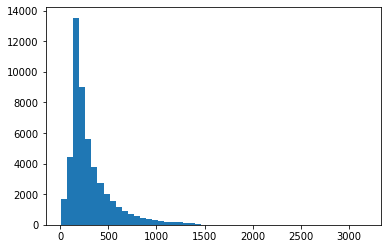

In [37]:
# preprocessing of data & splitting

caches_path = "/content/drive/My Drive/IPM AI/caches/"
mapped_cache_filename = os.path.join(caches_path, "imdb-mapped.cache")

mapped_ds = full_ds.map(eager_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
mapped_ds = mapped_ds.cache(filename=mapped_cache_filename)  # do the hard preprocessing at once & save it
mapped_ds = mapped_ds.cache()

len_cache_filename = os.path.join(caches_path, "imdb-mapped-lens.cache")
len_ds = (mapped_ds.map(lambda v, l: tf.size(v), num_parallel_calls=tf.data.experimental.AUTOTUNE)
                   .cache(filename=len_cache_filename))

stats = len_ds.reduce((tf.constant(0), tf.constant(-1)), lambda m, x: (m[0] + 1, tf.math.add(m[1], x)))
avg_len = (stats[1]/stats[0]).numpy()

print("Average length of vectors for reviews: {}".format(avg_len))

import matplotlib.pyplot as plt
x = np.fromiter(len_ds.as_numpy_iterator(), dtype=np.int32)
plt.hist(x, bins=50)
plt.show()

In [ ]:
# !rm -v /content/drive/My\ Drive/IPM\ AI/caches/imdb-test.cache*

rm: cannot remove '/content/drive/My Drive/IPM AI/caches/imdb-test.cache*': No such file or directory


In [38]:
clip_cache_filename = os.path.join(caches_path, "imdb-mapped-clipped.cache")
clip_ds = mapped_ds.map(clip_fill_to_size, num_parallel_calls=tf.data.experimental.AUTOTUNE)
clip_ds = clip_ds.cache(filename=clip_cache_filename)

In [ ]:
# next(iter(clip_ds))

In [40]:
# train, validation, test split

full_ds_shuffle_cache_filename = os.path.join(caches_path, "imdb-mapped-clipped-shuffle.cache")
prep_ds = clip_ds.cache()  # cache in-memory for faster shuffling
prep_ds = prep_ds.shuffle(full_ds_size)  # full shuffling of all data
prep_ds = prep_ds.cache(filename=full_ds_shuffle_cache_filename)  # save the result of expensive shuffle

train_ds_size = int(0.50 * full_ds_size)
val_ds_size = int(0.25 * full_ds_size)
test_ds_size = full_ds_size - train_ds_size - val_ds_size

train_ds = prep_ds.take(train_ds_size)
remaining = prep_ds.skip(train_ds_size)  
val_ds = remaining.take(val_ds_size)
test_ds = remaining.skip(val_ds_size)


# performances: cache & batch & prefetch

BATCH_SIZE = 128


train_cache_filename = os.path.join(caches_path, "imdb-train.cache")
train_ds = train_ds.cache()  # cache in-memory for faster shuffling
train_ds = train_ds.shuffle(train_ds_size)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.cache(filename=train_cache_filename)  # pre-made batches ready for training :)
train_ds = train_ds.cache()  # also keep in memory to reduce read time
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)  # prefetch for more efficient use of time when GPU is busy


val_cache_filename = os.path.join(caches_path, "imdb-val.cache")
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.cache(filename=val_cache_filename)
val_ds = val_ds.cache()
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)


test_cache_filename = os.path.join(caches_path, "imdb-test.cache")
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.cache(filename=test_cache_filename)
test_ds = test_ds.cache()
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# next(iter(train_ds))  # UPDATE: shouldn't take long now (UPDATE UPDATE: yes, only 2 seconds compared to 20 mins!)

In [41]:
reducer = lambda m, x: tf.math.maximum(m, x)
vocab_size = (mapped_ds.map(lambda x, l: tf.reduce_max(x))
                       .reduce(tf.constant(-1), reducer)).numpy() + 1
vocab_size

30148

### Purge cache

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output, Markdown

del_cache_button = widgets.Button(description='Delete Cache')
del_cache_out = widgets.Output()

def delete_file(filename):
  if os.path.exists(filename):
    os.remove(filename)
    return True
  else:
    return False

def delete_cache():
  return delete_file(prep_cache_filename)

def on_button_clicked(_):
  with del_cache_out:
    clear_output()
    if delete_cache():
      print(Markdown('''<span style='color: green'>Cache cleared!</span>'''))
    else:
      display(Markdown('''<span style='color: grey'>Cache empty!</span>'''))

del_cache_button.on_click(on_button_clicked)
display(del_cache_button, del_cache_out)

# Utilities

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [42]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 10.6 GB  | Proc size: 4.2 GB
GPU RAM Free: 13671MB | Used: 2609MB | Util  16% | Total 16280MB


In [54]:
def plot_history(history):
  history_dict = history.history
  history_dict.keys()

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()

In [ ]:
# %tensorboard --logdir logs

# Model #1

## Design

In [44]:
# build the damn model

from tensorflow.keras import layers

model_1 = keras.models.Sequential(name='sentiment')

## model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
##                          input_shape=[], dtype=tf.string))

model_1.add(layers.Embedding(vocab_size, 128, input_length=max_seq_len, mask_zero=True, name='embedding'))
model_1.add(layers.Flatten(name='flatten'))
model_1.add(layers.Dropout(0.2, name='dropout_1'))
model_1.add(layers.Dense(128, activation='relu', name='dense_1'))
model_1.add(layers.Dropout(0.1, name='dropout_2'))
model_1.add(layers.Dense(64, activation='relu', name='dense_2'))
model_1.add(layers.Dropout(0.05, name='dropout_3'))
model_1.add(layers.Dense(64, activation='relu', name='dense_3'))
model_1.add(layers.Dense(1, activation='sigmoid', name='label'))

model_1.build(input_shape=(None, max_seq_len))

model_1.summary()

Model: "sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         3858944   
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16384128  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0 

In [ ]:
# failed attempt at using bert layer. BERT-Large: OOM, BERT-Base: 0.50 accuracy :(

# from tensorflow.keras import layers

# input_ids = keras.Input(shape=(max_seq_len,), dtype='int32', name='input_ids')

# bert_layer = bert.BertModelLayer.from_params(bert_params, name="bert")

# dropout_1 = layers.Dropout(0.2, name='dropout_1')
# conv_1 = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1, name='conv_1')
# max_pooling_1 = layers.GlobalMaxPooling1D(name='max_pooling_1')

# dropout_2 = layers.Dropout(0.1, name='dropout_2')
# dense_1 = layers.Dense(128, activation='relu', name='dense_1')

# dropout_3 = layers.Dropout(0.05, name='dropout_3')
# dense_2 = layers.Dense(64, activation='relu', name='dense_2')

# label = layers.Dense(1, activation='sigmoid', name='label')

# output = label(dense_2(dropout_3(dense_1(dropout_2(
              #  max_pooling_1(conv_1(dropout_1(bert_layer(input_ids)))))))))

# model = keras.models.Model(inputs=[input_ids], outputs=[output], name='sentiment')
# model.build(input_shape=(None, max_seq_len))

# bert.load_bert_weights(bert_layer, bert_model_ckpt)      # should be called after model.build()

# model.summary()

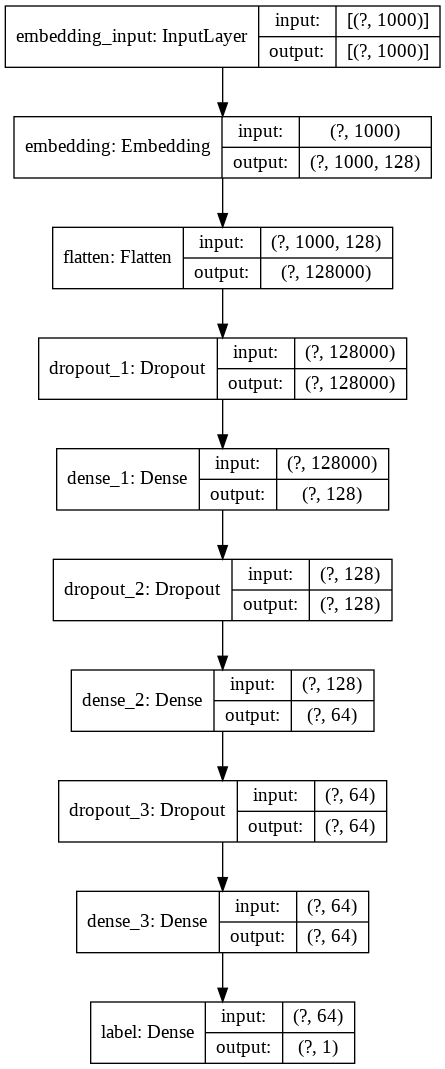

In [129]:
keras.utils.plot_model(model_1, show_shapes=True)

In [45]:
# compile it

from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

def compile_model(model):
  model.compile(optimizer=optimizers.Adam(),
                loss=losses.BinaryCrossentropy(from_logits=True),
                metrics=[metrics.binary_accuracy])

In [46]:
compile_model(model_1)

## Train

In [80]:
# train it

def train_model(model, epochs=20):
  early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode='max',
                                                    patience=5, restore_best_weights=True)

  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                patience=3, min_delta=0.001)

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  # tensorboard_cb = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  history = model.fit(train_ds,
                      epochs=epochs,
                      validation_data=val_ds,
                      callbacks=[early_stopping_cb, reduce_lr])
  return history

In [51]:
history_1 = train_model(model_1)

Epoch 1/20
196/196 [==============================] - 16s 80ms/step - loss: 0.6933 - binary_accuracy: 0.4981 - val_loss: 0.6924 - val_binary_accuracy: 0.5050
Epoch 2/20
196/196 [==============================] - 15s 78ms/step - loss: 0.6839 - binary_accuracy: 0.5288 - val_loss: 0.6811 - val_binary_accuracy: 0.5420
Epoch 3/20
196/196 [==============================] - 15s 77ms/step - loss: 0.6068 - binary_accuracy: 0.7584 - val_loss: 0.5728 - val_binary_accuracy: 0.8602
Epoch 4/20
196/196 [==============================] - 15s 77ms/step - loss: 0.5542 - binary_accuracy: 0.8850 - val_loss: 0.5615 - val_binary_accuracy: 0.8784
Epoch 5/20
196/196 [==============================] - 15s 76ms/step - loss: 0.5385 - binary_accuracy: 0.9199 - val_loss: 0.5570 - val_binary_accuracy: 0.8882
Epoch 6/20
196/196 [==============================] - 15s 78ms/step - loss: 0.5330 - binary_accuracy: 0.9321 - val_loss: 0.5557 - val_binary_accuracy: 0.8986
Epoch 7/20
196/196 [==============================] 

In [52]:
model_1.save('/content/drive/My Drive/IPM AI/Models/BERT-Tokenize-Embedding-Dense.h5')

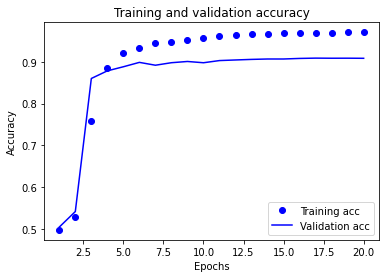

In [101]:
plot_history(history_1)

## Evaluate

In [67]:
model_1.evaluate(test_ds)

98/98 [==============================] - 2s 16ms/step - loss: 0.5447 - binary_accuracy: 0.9113


[0.5446987748146057, 0.9112799763679504]

# Model #2

## Design

In [73]:
# build the damn model

from tensorflow.keras import layers

model_2 = keras.models.Sequential(name='sentiment')

model_2.add(layers.Embedding(vocab_size, 128, input_length=max_seq_len, mask_zero=True, name='embedding'))
model_2.add(layers.Dropout(0.2, name='dropout_1'))
model_2.add(layers.Conv1D(128, 5, name='conv'))
model_2.add(layers.GlobalMaxPool1D(name='pool'))
model_2.add(layers.Dropout(0.1, name='dropout_2'))
model_2.add(layers.Dense(128, activation='relu', name='dense_1'))
model_2.add(layers.Dropout(0.05, name='dropout_3'))
model_2.add(layers.Dense(64, activation='relu', name='dense_2'))
model_2.add(layers.Dense(1, activation='sigmoid', name='label'))

model_2.build(input_shape=(None, max_seq_len))

model_2.summary()

Model: "sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         3858944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
conv (Conv1D)                (None, 996, 128)          82048     
_________________________________________________________________
pool (GlobalMaxPooling1D)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0 

In [74]:
compile_model(model_2)

## Train

In [75]:
history_2 = train_model(model_2, epochs=30)

Epoch 1/30
196/196 [==============================] - 16s 81ms/step - loss: 0.6787 - binary_accuracy: 0.5477 - val_loss: 0.6128 - val_binary_accuracy: 0.7414
Epoch 2/30
196/196 [==============================] - 16s 79ms/step - loss: 0.5968 - binary_accuracy: 0.7812 - val_loss: 0.5857 - val_binary_accuracy: 0.8190
Epoch 3/30
196/196 [==============================] - 16s 80ms/step - loss: 0.5774 - binary_accuracy: 0.8238 - val_loss: 0.5754 - val_binary_accuracy: 0.8522
Epoch 4/30
196/196 [==============================] - 16s 80ms/step - loss: 0.5544 - binary_accuracy: 0.8840 - val_loss: 0.5610 - val_binary_accuracy: 0.8951
Epoch 5/30
196/196 [==============================] - 16s 80ms/step - loss: 0.5441 - binary_accuracy: 0.9092 - val_loss: 0.5551 - val_binary_accuracy: 0.9062
Epoch 6/30
196/196 [==============================] - 16s 80ms/step - loss: 0.5378 - binary_accuracy: 0.9231 - val_loss: 0.5522 - val_binary_accuracy: 0.9124
Epoch 7/30
196/196 [==============================] 

In [78]:
model_2.save('/content/drive/My Drive/IPM AI/Models/BERT-Tokenize-Conv-Dense.h5')

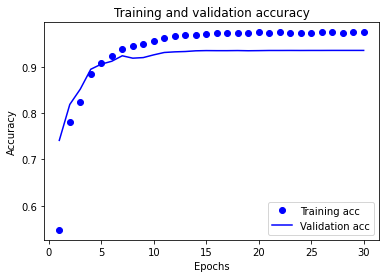

In [100]:
plot_history(history_2)

## Evaluate

In [77]:
model_2.evaluate(test_ds)

98/98 [==============================] - 2s 17ms/step - loss: 0.5349 - binary_accuracy: 0.9339


[0.5349380970001221, 0.9339200258255005]

# Model #3

## Design

In [93]:
# build the damn model

from tensorflow.keras import layers

model_3 = keras.models.Sequential(name='sentiment')

model_3.add(layers.Embedding(vocab_size, 128, input_length=max_seq_len, mask_zero=True, name='embedding'))
model_3.add(layers.Dropout(0.2, name='dropout_1'))
model_3.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True), name='lstm'))
model_3.add(layers.Dropout(0.1, name='dropout_2'))
model_3.add(layers.Conv1D(64, 5, name='conv'))
model_3.add(layers.GlobalMaxPooling1D(name='pool'))
# model_3.add(layers.Dropout(0.05, name='dropout_3'))
model_3.add(layers.Dense(128, activation='relu', name='dense_1'))

# model_3.add(layers.Dense(64, activation='relu', name='dense_2'))
# model_3.add(layers.Dense(64, activation='relu', name='dense_3'))
model_3.add(layers.Dense(1, activation='sigmoid', name='label'))

model_3.build(input_shape=(None, max_seq_len))

model_3.summary()

Model: "sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 128)         3858944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
lstm (Bidirectional)         (None, 1000, 64)          41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000, 64)          0         
_________________________________________________________________
conv (Conv1D)                (None, 996, 64)           20544     
_________________________________________________________________
pool (GlobalMaxPooling1D)    (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               83

In [94]:
compile_model(model_3)

## Train

In [95]:
history_3 = train_model(model_3)

Epoch 1/20
196/196 [==============================] - 37s 187ms/step - loss: 0.6264 - binary_accuracy: 0.7000 - val_loss: 0.5760 - val_binary_accuracy: 0.8293
Epoch 2/20
196/196 [==============================] - 35s 177ms/step - loss: 0.5646 - binary_accuracy: 0.8626 - val_loss: 0.5616 - val_binary_accuracy: 0.8757
Epoch 3/20
196/196 [==============================] - 35s 176ms/step - loss: 0.5519 - binary_accuracy: 0.8928 - val_loss: 0.5589 - val_binary_accuracy: 0.8945
Epoch 4/20
196/196 [==============================] - 35s 176ms/step - loss: 0.5514 - binary_accuracy: 0.8938 - val_loss: 0.5582 - val_binary_accuracy: 0.8963
Epoch 5/20
196/196 [==============================] - 35s 176ms/step - loss: 0.5475 - binary_accuracy: 0.9004 - val_loss: 0.5627 - val_binary_accuracy: 0.8930
Epoch 6/20
196/196 [==============================] - 34s 176ms/step - loss: 0.5501 - binary_accuracy: 0.8985 - val_loss: 0.5654 - val_binary_accuracy: 0.8882
Epoch 7/20
196/196 [==========================

In [99]:
model_3.save('/content/drive/My Drive/IPM AI/Models/BERT-Tokenize-LSTM-Conv-Dense.h5')

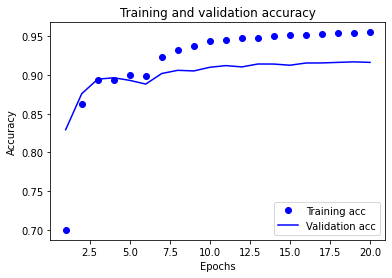

In [96]:
plot_history(history_3)

## Evaluate

In [97]:
model_3.evaluate(test_ds)

98/98 [==============================] - 5s 53ms/step - loss: 0.5440 - binary_accuracy: 0.9138


[0.5440124273300171, 0.9137600064277649]

# Model #4

## Design

In [114]:
# build the damn model

from tensorflow.keras import layers

model_4 = keras.models.Sequential(name='sentiment')

model_4.add(layers.Embedding(vocab_size, 128, input_length=max_seq_len, mask_zero=True))
model_4.add(layers.Dropout(0.2, name='dropout_1'))
model_4.add(layers.Conv1D(128, 7, name='conv'))
model_4.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), name='lstm'))
model_4.add(layers.GlobalMaxPooling1D(name='pool'))
model_4.add(layers.Dropout(0.1, name='dropout_2'))
model_4.add(layers.Dense(128, activation='relu', name='dense_1'))
model_4.add(layers.Dropout(0.05, name='dropout_3'))
model_4.add(layers.Dense(64, activation='relu', name='dense_2'))
# model.add(layers.Dense(64, activation='relu', name='dense_3'))
model_4.add(layers.Dense(1, activation='sigmoid', name='label'))

model_4.build(input_shape=(None, max_seq_len))

model_4.summary()

Model: "sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 1000, 128)         3858944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 128)         0         
_________________________________________________________________
conv (Conv1D)                (None, 994, 128)          114816    
_________________________________________________________________
lstm (Bidirectional)         (None, 994, 128)          98816     
_________________________________________________________________
pool (GlobalMaxPooling1D)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16

In [115]:
compile_model(model_4)

## Train

In [116]:
history_4 = train_model(model_4)

Epoch 1/20
196/196 [==============================] - 42s 213ms/step - loss: 0.6371 - binary_accuracy: 0.6798 - val_loss: 0.5969 - val_binary_accuracy: 0.8063
Epoch 2/20
196/196 [==============================] - 42s 212ms/step - loss: 0.5976 - binary_accuracy: 0.7897 - val_loss: 0.5867 - val_binary_accuracy: 0.8318
Epoch 3/20
196/196 [==============================] - 41s 210ms/step - loss: 0.5769 - binary_accuracy: 0.8372 - val_loss: 0.5790 - val_binary_accuracy: 0.8494
Epoch 4/20
196/196 [==============================] - 41s 208ms/step - loss: 0.5681 - binary_accuracy: 0.8545 - val_loss: 0.5723 - val_binary_accuracy: 0.8633
Epoch 5/20
196/196 [==============================] - 40s 206ms/step - loss: 0.5560 - binary_accuracy: 0.8825 - val_loss: 0.5654 - val_binary_accuracy: 0.8708
Epoch 6/20
196/196 [==============================] - 42s 212ms/step - loss: 0.5517 - binary_accuracy: 0.8919 - val_loss: 0.5625 - val_binary_accuracy: 0.8835
Epoch 7/20
196/196 [==========================

In [117]:
model_4.save('/content/drive/My Drive/IPM AI/Models/BERT-Tokenize-Conv-LSTM-Pool.h5')

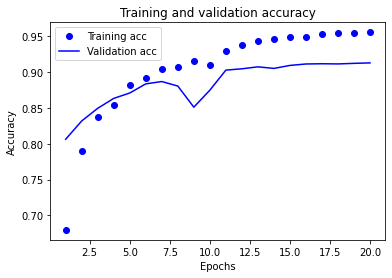

In [127]:
plot_history(history_4)

## Evaluate

In [119]:
model_4.evaluate(test_ds)

98/98 [==============================] - 6s 61ms/step - loss: 0.5456 - binary_accuracy: 0.9109


[0.5455991625785828, 0.9108800292015076]

# Conclusion

Best model: model #2

Test accuracy: 93.392